# Time Gap Distribution Estimation

Some papers treat order arrival as a **Possion Process**, thus the time gap between trades is an **Exponential Distribution**. This notebook will use BTC and ETH per trade data to verify this hypothesis.

In [1]:
import gc
import os
from typing import Dict, List, Tuple

import dask.bag as db
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats

## Read Trade Data

In [2]:
# Trades are sorted by trade_id already(except BitMEX, which is sorted by timestamp)
PER_TRADE_DATA_DIR = '/data/csv'

In [3]:
BTC_PAIRS = [
    ('Binance', 'Spot', 'BTC_USDT'),
    ('Binance', 'Swap', 'BTC_USDT'),
    ('BitMEX', 'Swap', 'BTC_USD'),
    ('Huobi', 'Spot', 'BTC_USDT'),
    ('Huobi', 'Swap', 'BTC_USD'),
    ('OKEx', 'Spot', 'BTC_USDT'),
    ('OKEx', 'Swap', 'BTC_USDT'),
    ('OKEx', 'Swap', 'BTC_USD'),
]

ETH_PAIRS = [
    ('Binance', 'Spot', 'ETH_USDT'),
    ('Binance', 'Swap', 'ETH_USDT'),
    ('BitMEX', 'Swap', 'ETH_USD'),
    ('Huobi', 'Spot', 'ETH_USDT'),
    ('Huobi', 'Swap', 'ETH_USD'),
    ('OKEx', 'Spot', 'ETH_USDT'),
    ('OKEx', 'Swap', 'ETH_USDT'),
    ('OKEx', 'Swap', 'ETH_USD'),
]

In [4]:
def get_csv_file(exchange: str, market_type: str, pair: str)->str:
    assert market_type == 'Spot' or market_type == 'Swap'
    return os.path.join(PER_TRADE_DATA_DIR, f'{exchange}.{market_type}.{pair}.csv')

In [5]:
get_csv_file(*BTC_PAIRS[0])

'/data/csv/Binance.Spot.BTC_USDT.csv'

In [6]:
get_csv_file(*ETH_PAIRS[-1])

'/data/csv/OKEx.Swap.ETH_USD.csv'

In [7]:
def read_csv(trade_csv_file: str)->pd.DataFrame:
    df = pd.read_csv(trade_csv_file, engine='c',
                     dtype={'exchange': 'category', 'marketType': 'category', 'pair': 'category',
                            'timestamp': 'int64', 'price': 'float32',
                            'quantity': 'float32', 'side': 'bool', 'trade_id': 'string'})
    return df

In [8]:
read_csv(get_csv_file(*ETH_PAIRS[-1])).head()

,exchange,marketType,pair,timestamp,price,quantity,side,trade_id
0,OKEx,Swap,ETH_USD,1588291218207,206.179993,3.880105,True,14122344
1,OKEx,Swap,ETH_USD,1588291218207,206.179993,2.134058,True,14122345
2,OKEx,Swap,ETH_USD,1588291218207,206.179993,2.425066,True,14122346
3,OKEx,Swap,ETH_USD,1588291218207,206.149994,2.279893,True,14122348
4,OKEx,Swap,ETH_USD,1588291218207,206.149994,1.261218,True,14122349


## Calculate Time Gaps Between Trades

In [9]:
def get_time_gaps(exchange: str, market_type: str, pair: str)->pd.Series:
    df = read_csv(get_csv_file(exchange, market_type, pair))

    time_gaps = df['timestamp'].diff(1).dropna().astype('int64')  # in milliseconds

    # remove outliers
    max_gap = time_gaps.quantile(0.95)
    time_gaps = time_gaps[time_gaps.between(0, max_gap, inclusive=False)]

    time_gaps.rename(f'{exchange}_{market_type}_{pair}', inplace=True)

    del df
    gc.collect()
    return time_gaps

## Plot Histogram

Assume that trade arrival is a Poisson process, then the time gap between trades would be **Exponentially distributed**, therefore we can use `fit=stats.expon` to fit the data.

In [10]:
def plot_hist(exchange_market_pairs: List[Tuple[str, str, str]])->None:
    '''Plot histogram of time gaps.'''
    assert len(exchange_market_pairs) == 8
    time_gaps_arr = db.from_sequence(exchange_market_pairs).map(lambda x: get_time_gaps(*x)).compute()
    f, axes = plt.subplots(nrows=4, ncols=2, figsize=(13, 20))
    current_palette = sns.color_palette(palette='bright', n_colors=len(BTC_PAIRS))
    for i in range(8):
        sns.distplot( time_gaps_arr[i], kde=False, fit=stats.expon, color=current_palette[i], ax=axes[i//2, i%2])

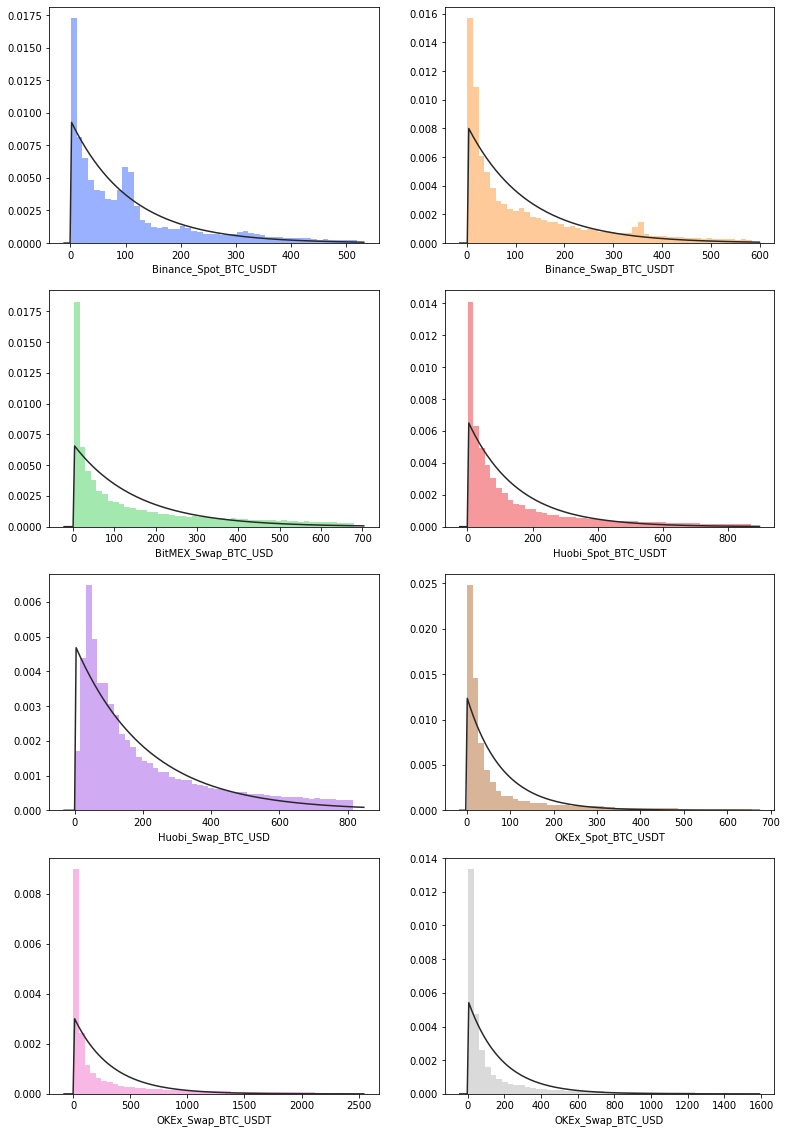

In [11]:
plot_hist(BTC_PAIRS)

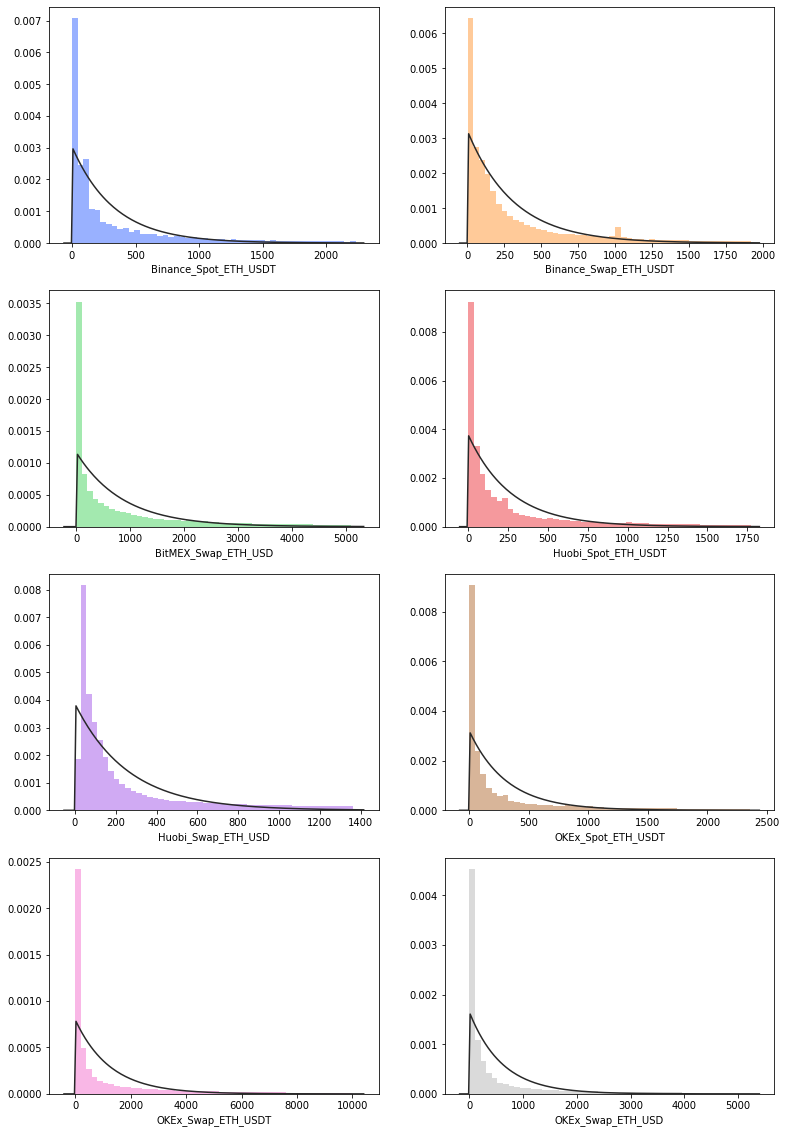

In [12]:
plot_hist(ETH_PAIRS)

**Conclusion: From each diagram above, we can see that time gaps between trades fit an exponential distribution quite well.**

## References

* [Visualizing the distribution of a dataset - seaborn](https://seaborn.pydata.org/tutorial/distributions.html)
* [Choosing color palettes - seaborn](https://seaborn.pydata.org/tutorial/color_palettes.html)
* [Cont, Rama, Sasha Stoikov, Rishi Talreja. 2010b. A stochastic model for order book dynamics. Operations Research 58 549–563.](https://pubsonline.informs.org/doi/abs/10.1287/opre.1090.0780)
* [V. Gontis, B. Kaulakys, and J. Ruseckas, “Trading activity as driven poisson process: comparison with empirical data,” Physica A, vol. 387, pp. 3891–3896, 2008.](https://www.sciencedirect.com/science/article/abs/pii/S0378437108002574)
* [Understanding Waiting Times Between Events with the Poisson and Exponential Distributions](https://nbviewer.jupyter.org/github/nicolewhite/notebooks/blob/master/Poisson.ipynb)
* [泊松分布的现实意义是什么，为什么现实生活多数服从于泊松分布？- 知乎](https://www.zhihu.com/question/26441147)
* [泊松分布 - 维基百科，自由的百科全书](https://zh.wikipedia.org/wiki/泊松分布)
* [泊松分布和指数分布：10分钟教程 - 阮一峰的网络日志](http://www.ruanyifeng.com/blog/2015/06/poisson-distribution.html)